In [1]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd
import rdata
import time

In [2]:
def create_maldi_image(spectra_list):
    n = int(math.sqrt(len(spectra_list)))
    # Create an empty numpy array to store the maldi image
    maldi_image = np.zeros((n, n))
    
    for row in range(n):
        for col in range(n):
            avg_value = np.sum(spectra_list[row * n + col]) / len(spectra_list[row * n + col])
            maldi_image[row, col] = np.round(avg_value * 255).astype(np.uint8)
            
    return maldi_image

In [3]:
def recursionStart(spectra):
    featurePairs = []
    maxima = []
    minima = []
    
    for i in range(1, len(spectra) - 1):
        if spectra[i] > spectra[i-1]:
            if spectra[i] >= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] > spectra[j]:
                        maxima.append([i, spectra[i]])
                        break
                    elif spectra[i] < spectra[j]:
                        break
        if spectra[i] < spectra[i-1]:
            if spectra[i] <= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] < spectra[j]:
                        minima.append([i, spectra[i]])
                        break
                    elif spectra[i] > spectra[j]:
                        break
    maxima.sort(key = lambda element: element[1], reverse = True)
    minima.sort(key = lambda element: element[1])
    
    if len(maxima) == 0:
        return -1
    globalMaxima = maxima.pop(0)
    featurePairs.append([globalMaxima[0], globalMaxima[1] - minima[0][1]])
    
    recursionStep(0, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    recursionStep(len(spectra) - 1, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    
    return featurePairs

def recursionStep(start, end, maxima, minima, featurePairs):
    factor = 1
    if end < start:
        factor = -1
    currentMaxima = []
    for i in range(len(maxima)):
        position = maxima[i][0]
        if start * factor < position * factor and position * factor < end * factor:
            currentMaxima.append(maxima[i])
    if len(currentMaxima) == 0:
        return
    localMaxima = currentMaxima.pop(0)
    recursionStep(start, localMaxima[0], currentMaxima.copy(), minima.copy(), featurePairs)
    currentMinima = []
    for i in range(len(minima)):
        position = minima[i][0]
        if localMaxima[0] * factor < position * factor and position * factor < end * factor:
            currentMinima.append(minima[i])
    localMinima = currentMinima.pop(0)
    featurePairs.append([localMaxima[0], localMaxima[1] - localMinima[1]])
    recursionStep(localMinima[0], localMaxima[0], currentMaxima.copy(), currentMinima.copy(), featurePairs)
    recursionStep(localMinima[0], end, currentMaxima.copy(), currentMinima.copy(), featurePairs)

def getPersistenceTransformation(data_X):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)
    return spectras
                
       
def getPercantageForSpectra(spectras, length, k):
    transformationForSpectra = []
    for i in range(0, len(spectras)):
        if len(spectras[i]) == 1:
            var_k = 0
        else:
            var_k = k
        transformation = [0] * length
        featurePairs = spectras[i][0:round(var_k*len(spectras[i]))]
        for x, fx in featurePairs:
            transformation[x] = fx
        transformationForSpectra.append(transformation)
    
    return transformationForSpectra

In [4]:
def read_data(path):
    parsed = rdata.parser.parse_file(path)
    converted = rdata.conversion.convert(parsed)
    data = np.array(list(converted.values()))[0]
    return data

In [5]:
def add_gaussian_noise(image, mean=0, std=1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    noise = np.random.normal(loc=mean, scale=std, size=image.shape)
    return image + noise

def add_poisson_noise(spectrum, lam=1, seed = 123):
    if seed is not None:
        np.random.seed(seed)
    
    noisy_spectrum = np.random.poisson(lam=lam, size=spectrum.shape) + spectrum
    return noisy_spectrum

In [10]:
def apply_pt(data, noise_type, k = [0.05, 0.1], lam = [0.01, 0.05, 0.1], mean = 0.1, std = [0.1, 0.3, 0.5], seed = 123, percentage = .05, baseline = 0):
    
    if noise_type == 'gaussian':
        length = len(std)
        noisy_data = []
        captions = []
        for noise in std:
            noisy_data.append(add_gaussian_noise(data, mean=mean, std=noise, seed=seed))
            captions.append('Gaussian Noise\nstd = {}'.format(noise))
    elif noise_type == 'poisson':
        length = len(lam)
        noisy_data = []
        captions = []
        for noise in lam:
            noisy_data.append(add_poisson_noise(data, lam = noise, seed=seed))
            captions.append('Poisson Noise\nlam = {}'.format(noise))
    elif noise_type == 'speckle':
        noisy_data = add_speckle_noise(data, seed = seed)
        caption = 'Speckel Noise'.format(lam)
    else:
        noisy_data = add_gaussian_noise(data, mean=mean, std=std, seed=seed)
        caption = 'Noise'
        
    analyse_time = []
    pt_data = []
    
    for noisyData in noisy_data:
        st = time.time()
        pt_data.append(getPersistenceTransformation(data_X = noisyData))
        et = time.time()   
        analyse_time.append(et - st)
    
    pt = []
    images = []
    img = create_maldi_image(data)
    labels = []
    
    for i in range(len(noisy_data)):
        images.append(img)
        labels.append('Ground Truth')
        images.append(create_maldi_image(noisy_data[i]))
        labels.append(captions[i])
        for k_value in k:
            temp = getPercantageForSpectra(pt_data[i], len(data[0]), k_value)
            pt.append(temp)
            images.append(create_maldi_image(temp))
            labels.append('Transformation\nk = {}%'.format(k_value * 100))
    
    matplotlib.style.use('ggplot')
    fig, axes = plt.subplots(nrows=length, ncols=2 + len(k), figsize=(10, 10), dpi=100)
    
    for i in range(length):
        for j in range(2 + len(k)):
            axes[i, j].imshow(images[i*(2+len(k))+j], cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(labels[i*(2+len(k))+j])
    plt.tight_layout()
    plt.savefig('{}.png'.format(noise_type))
    plt.show()
    return images, labels, noisy_data

TypeError: Image data of dtype object cannot be converted to float

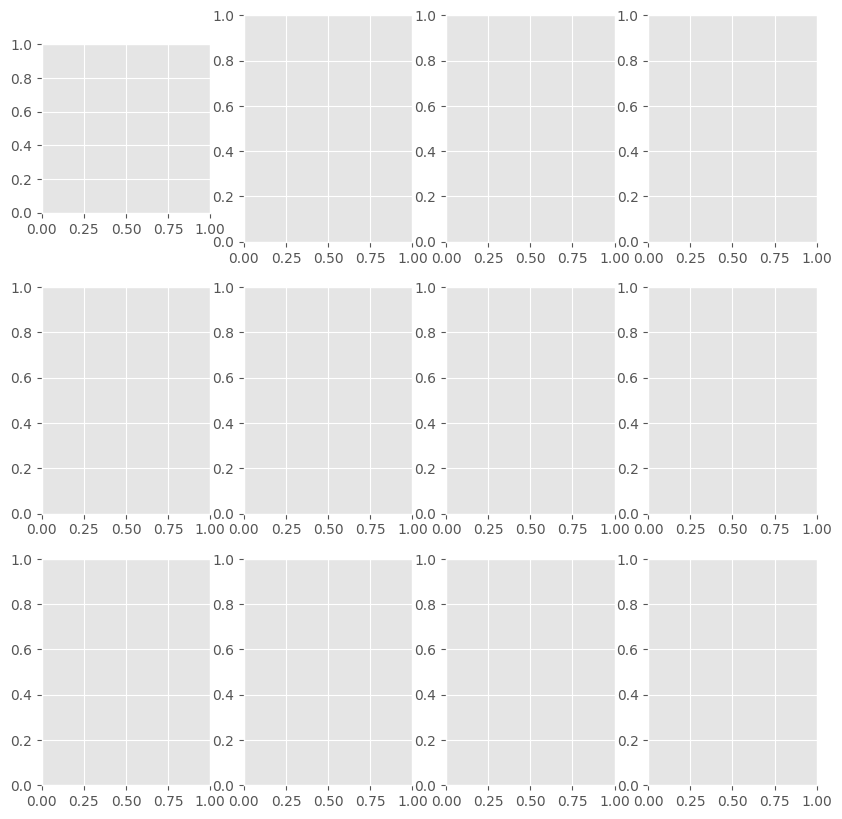

In [7]:
images_gaus, lable_gaus, noisy_data_gaus = noisy_data_gaus = apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_0.RData"), noise_type = 'gaussian', k = [0.05, 0.1], mean = 0.1, std = [0.1, 0.3, 0.5])

In [ ]:
# Plot the NumPy array
matplotlib.style.use('ggplot')
data = read_data("data/image_data_baseline_60x60_baseline_0.RData")

plt.plot(noisy_data_gaus[2][2140], color = 'green', alpha=0.5, label = 'std = 0.5')
plt.plot(noisy_data_gaus[1][2140], color = 'red', alpha=0.5, label = 'std = 0.3')
plt.plot(noisy_data_gaus[0][2140], color = 'blue', alpha=0.5, label = 'std = 0.1')
plt.plot(data[2140], color = 'black', label = 'Ground Truth', linewidth=3)
plt.xlim(1500, 3000)

# Set labels and title
plt.legend()
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Gausian Noise')
plt.savefig('gaussian_spectra.png')

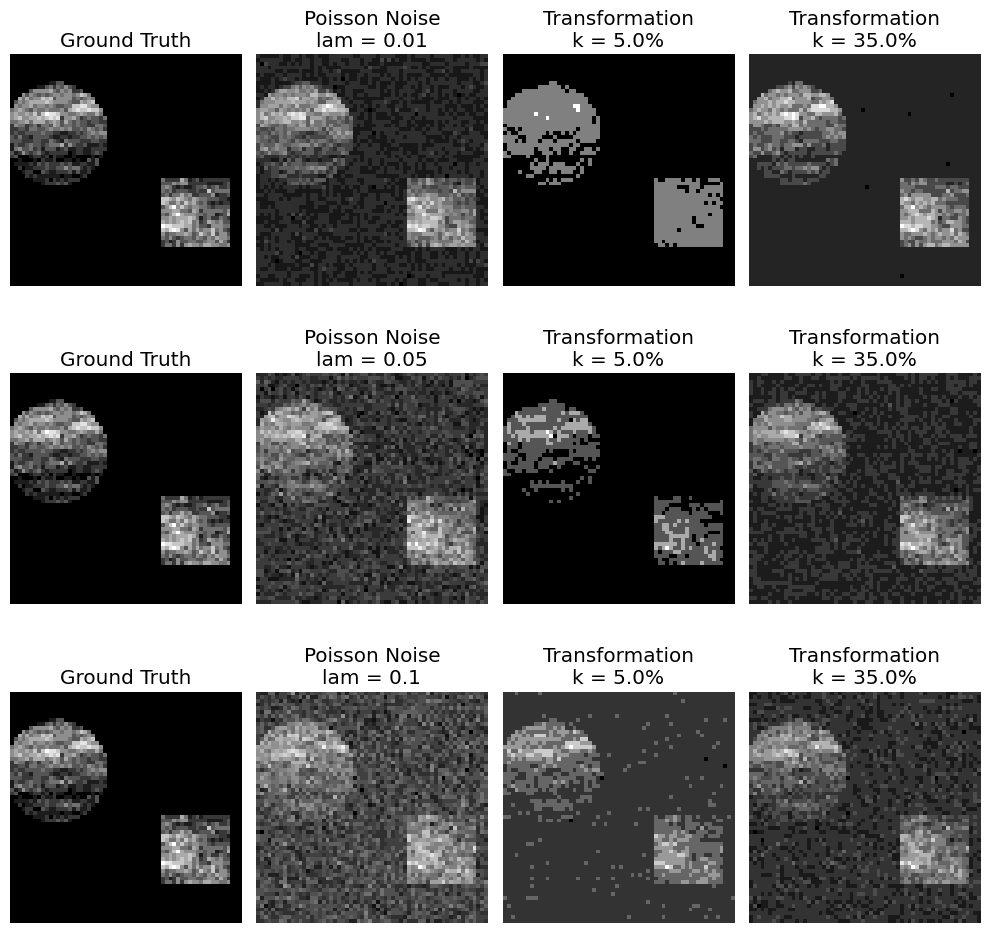

In [11]:
images_pois, lable_pois, noisy_data_pois = apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_0.RData"), noise_type = 'poisson', k = [0.05, 0.35], lam = [0.01, 0.05, 0.1])

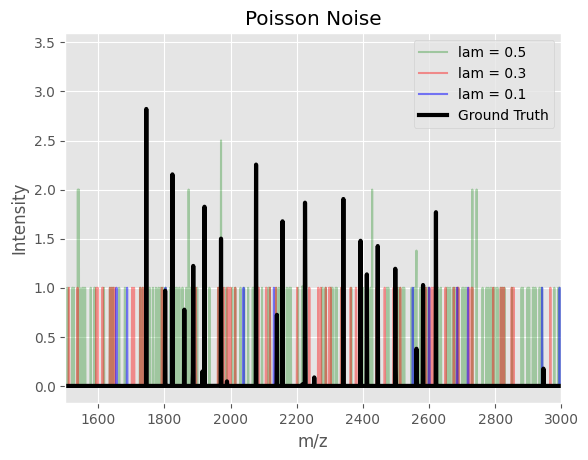

In [12]:
# Plot the NumPy array
matplotlib.style.use('ggplot')
data = read_data("data/image_data_baseline_60x60_baseline_0.RData")

plt.plot(noisy_data_pois[2][2140], color = 'green', alpha=0.3, label = 'lam = 0.5')
plt.plot(noisy_data_pois[1][2140], color = 'red', alpha=0.4, label = 'lam = 0.3')
plt.plot(noisy_data_pois[0][2140], color = 'blue', alpha=0.5, label = 'lam = 0.1')
plt.plot(data[2140], color = 'black', label = 'Ground Truth', linewidth=3)
plt.xlim(1500, 3000)

# Set labels and title
plt.legend()
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Poisson Noise')
plt.savefig('poisson_spectra.png')